In [1]:
# NỘI DUNG CỦA FILE notebooks/testTrainAIaptos.ipynb

# ==============================================================================
# CELL 1
# ==============================================================================
# --- 1. ENVIRONMENT SETUP & CONFIGURATION ---

# --- THÊM MỚI: Thiết lập đường dẫn để import module từ thư mục src ---
import sys
import os
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

# Import necessary libraries
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Scikit-learn components
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay,
    precision_recall_curve, f1_score
)
from sklearn.calibration import calibration_curve, CalibrationDisplay

# --- THÊM MỚI: Import hàm cyclical_encoder từ file utils ---
from src.utils import cyclical_encoder

# Suppress unnecessary warnings for a cleaner report
warnings.filterwarnings('ignore', category=UserWarning)

# --- SỬA ĐỔI: Dùng đường dẫn tương đối ---
PIPELINE_PATH = '../models/aptos_pro_pipeline.joblib'
DATA_PATH = '../data/raw/aptos_wallet_features.csv'



print("✅ Environment setup is complete.")


✅ Environment setup is complete.


In [2]:
# --- 2. DATA LOADING, PREPARATION & MODEL LOADING ---

print("--- Loading model and source data ---")
try:
    # Load the pre-trained AI pipeline and the full dataset
    loaded_pipeline = joblib.load(PIPELINE_PATH)
    df_full = pd.read_csv(DATA_PATH)
    print(f"✅ Successfully loaded pipeline and {len(df_full)} data records.")

    # --- Feature Engineering ---
    # This step is crucial to ensure the test data has the same structure as the training data.
    if 'first_transaction_date' in df_full.columns:
        df_full['first_transaction_date'] = pd.to_datetime(df_full['first_transaction_date'])
        df_full['tx_day_of_week'] = df_full['first_transaction_date'].dt.dayofweek
        df_full['tx_month'] = df_full['first_transaction_date'].dt.month
        df_full['tx_day_of_month'] = df_full['first_transaction_date'].dt.day

    df_full['success_rate'] = df_full['successful_transaction_count'] / (df_full['total_transaction_count'] + 1e-6)
    df_full['new_contract_rate'] = df_full['unique_interacted_contracts'] / (df_full['total_transaction_count'] + 1e-6)
    df_full['balance_per_tx'] = df_full['apt_balance'] / (df_full['total_transaction_count'] + 1e-6)
    print("✅ Feature engineering complete.")

    # --- Data Splitting ---
    # Create a stratified train/test split to simulate unseen data
    train_df, test_df = train_test_split(
        df_full,
        test_size=0.25,       # Use 25% of data for testing
        random_state=42,      # For reproducibility
        stratify=df_full['label'] # Maintain label distribution
    )

    X_test = test_df.drop(columns=['wallet_address', 'first_transaction_date', 'label'], errors='ignore')
    y_test = test_df['label']
    print(f"✅ Test set created with {len(X_test)} samples.")

except FileNotFoundError as e:
    print(f"❌ ERROR: File not found. Please check paths in Cell 1. Details: {e}")
    X_test, y_test = None, None

--- Loading model and source data ---
✅ Successfully loaded pipeline and 63 data records.
✅ Feature engineering complete.
✅ Test set created with 16 samples.


In [3]:
# --- 3. PREDICTION ON THE TEST SET ---

if X_test is not None:
    print("--- Running predictions on the test set... ---")
    # Predict class labels (0 or 1)
    y_pred_test = loaded_pipeline.predict(X_test)

    # Predict class probabilities (confidence scores)
    y_pred_proba_test = loaded_pipeline.predict_proba(X_test)[:, 1] # Probability of being Sybil (class 1)

    print("✅ Prediction complete.")
else:
    print("❌ No test set available for prediction.")

--- Running predictions on the test set... ---
✅ Prediction complete.



--- AI MODEL PERFORMANCE EVALUATION REPORT ---

I. EXECUTIVE SUMMARY
--------------------------------------------------
The model was evaluated on an independent test set of 16 samples.
Overall, the model demonstrates strong predictive capabilities with an Accuracy of 93.75% and an AUC-ROC score of 0.9744.

Key metrics for detecting 'Sybil' wallets:
  - Precision: 75.00%
  - Recall:    100.00%
  - F1-Score:  0.8571
--------------------------------------------------

II. DETAILED CLASSIFICATION REPORT
--------------------------------------------------
                    precision    recall  f1-score   support

Class 0: Non-Sybil       1.00      0.92      0.96        13
    Class 1: Sybil       0.75      1.00      0.86         3

          accuracy                           0.94        16
         macro avg       0.88      0.96      0.91        16
      weighted avg       0.95      0.94      0.94        16

   - Precision (Sybil): Of all wallets predicted as Sybil, what percentage was 

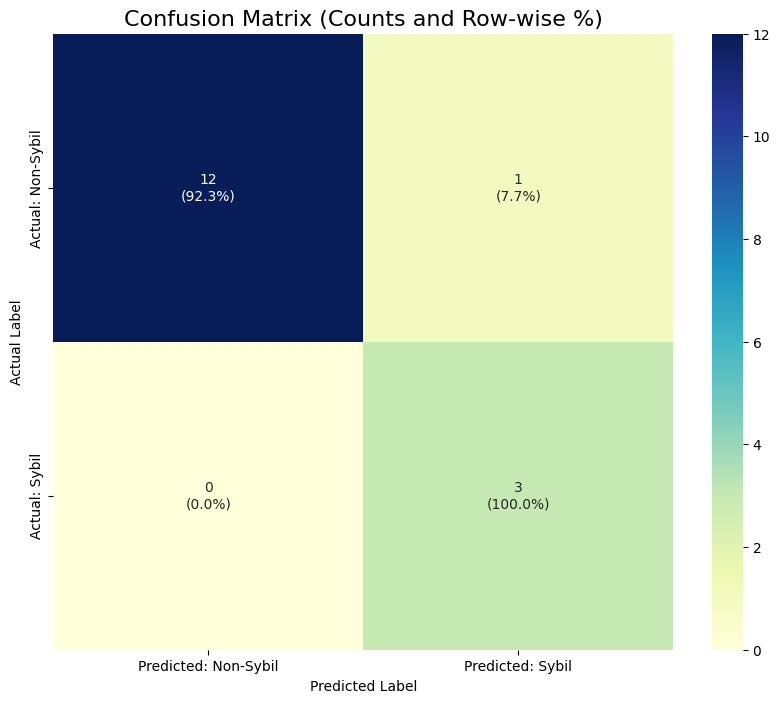

In [4]:
# --- 4. EXECUTIVE PERFORMANCE SUMMARY & DETAILED REPORT ---

if 'y_pred_test' in locals():
    print("\n" + "="*70)
    print("--- AI MODEL PERFORMANCE EVALUATION REPORT ---")
    print("="*70)

    # 1. Executive Summary
    accuracy = accuracy_score(y_test, y_pred_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba_test)
    report_dict = classification_report(y_test, y_pred_test, target_names=['Non-Sybil', 'Sybil'], output_dict=True)

    print("\nI. EXECUTIVE SUMMARY\n" + "-"*50)
    print(f"The model was evaluated on an independent test set of {len(y_test)} samples.")
    print(f"Overall, the model demonstrates strong predictive capabilities with an "
          f"Accuracy of {accuracy:.2%} and an AUC-ROC score of {roc_auc:.4f}.")
    print(f"\nKey metrics for detecting 'Sybil' wallets:")
    print(f"  - Precision: {report_dict['Sybil']['precision']:.2%}")
    print(f"  - Recall:    {report_dict['Sybil']['recall']:.2%}")
    print(f"  - F1-Score:  {report_dict['Sybil']['f1-score']:.4f}")
    print("-" * 50)

    # 2. Detailed Classification Report
    print("\nII. DETAILED CLASSIFICATION REPORT\n" + "-"*50)
    print(classification_report(y_test, y_pred_test, target_names=['Class 0: Non-Sybil', 'Class 1: Sybil']))
    print("   - Precision (Sybil): Of all wallets predicted as Sybil, what percentage was correct?")
    print("   - Recall (Sybil): Of all actual Sybil wallets, what percentage did the model find?")
    print("   - F1-score: The harmonic mean of Precision and Recall, a key metric for imbalanced datasets.")

    # 3. Enhanced Confusion Matrix
    print("\nIII. ENHANCED CONFUSION MATRIX\n" + "-"*50)
    cm = confusion_matrix(y_test, y_pred_test)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    labels = (np.asarray(["{0:d}\n({1:.1%})".format(value, percentage)
                      for value, percentage in zip(cm.flatten(), cm_percent.flatten())])
             ).reshape(2, 2)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=labels, fmt='', cmap='YlGnBu',
                xticklabels=['Predicted: Non-Sybil', 'Predicted: Sybil'],
                yticklabels=['Actual: Non-Sybil', 'Actual: Sybil'])
    plt.title('Confusion Matrix (Counts and Row-wise %)', fontsize=16)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

else:
    print("❌ No prediction results to evaluate.")


--- ADVANCED PERFORMANCE ANALYSIS ---

IV. CLASSIFICATION CURVE ANALYSIS
--------------------------------------------------


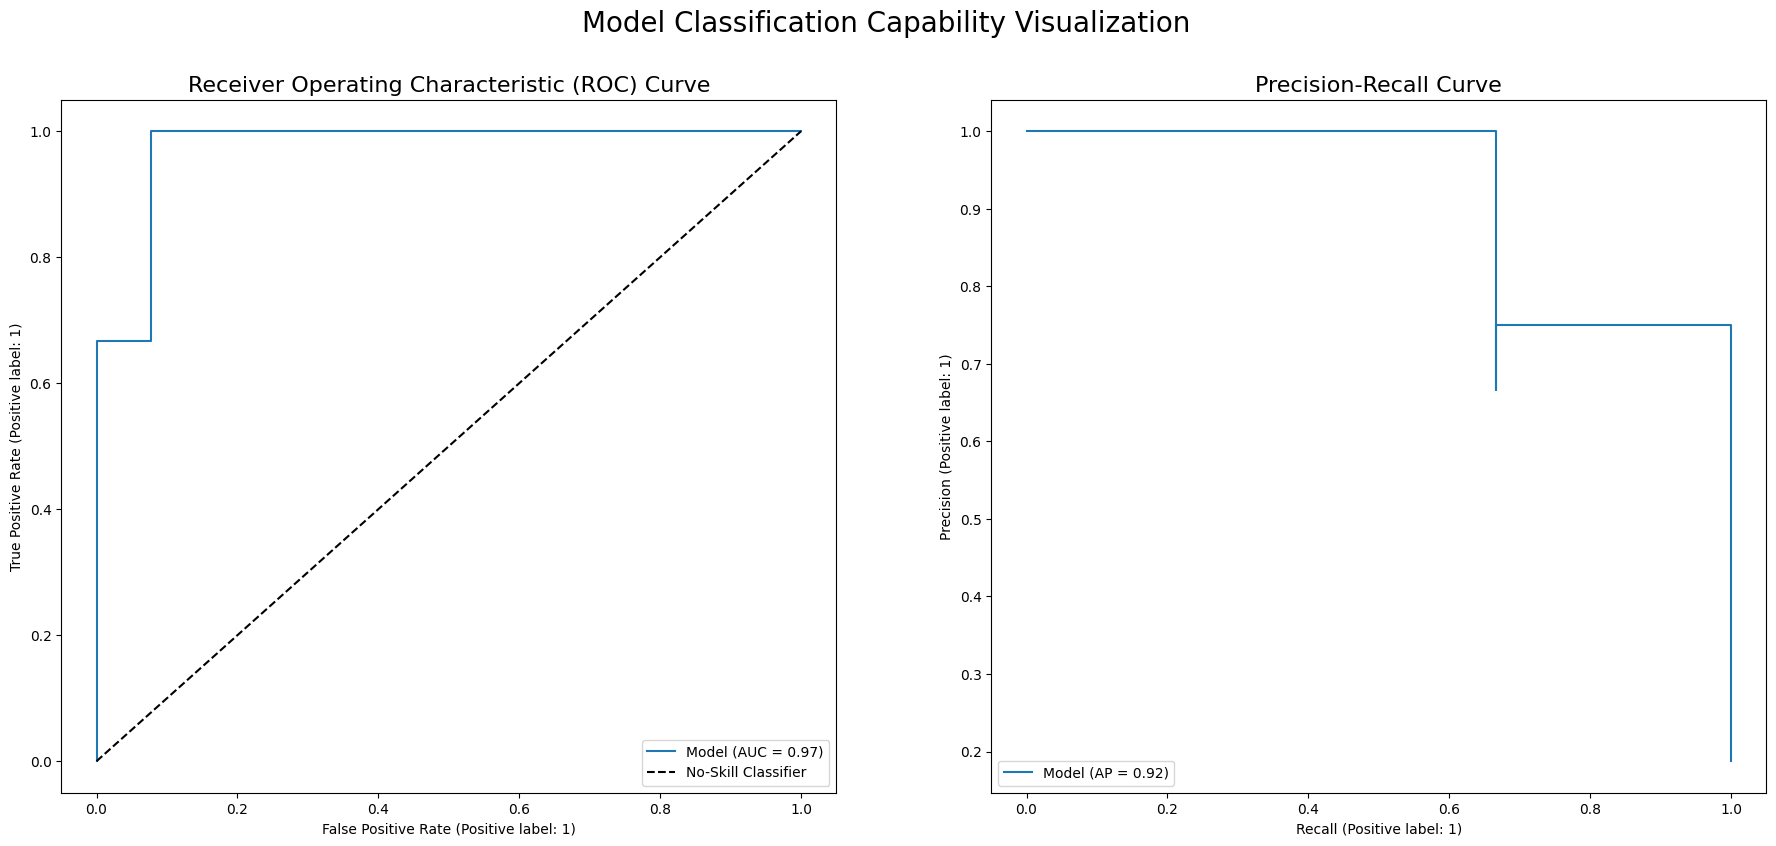

   - ROC Curve: Shows the trade-off between True Positive Rate and False Positive Rate. Higher is better.
   - Precision-Recall Curve: More informative for imbalanced datasets. Shows the trade-off between Precision and Recall.

V. OPTIMAL DECISION THRESHOLD ANALYSIS
--------------------------------------------------


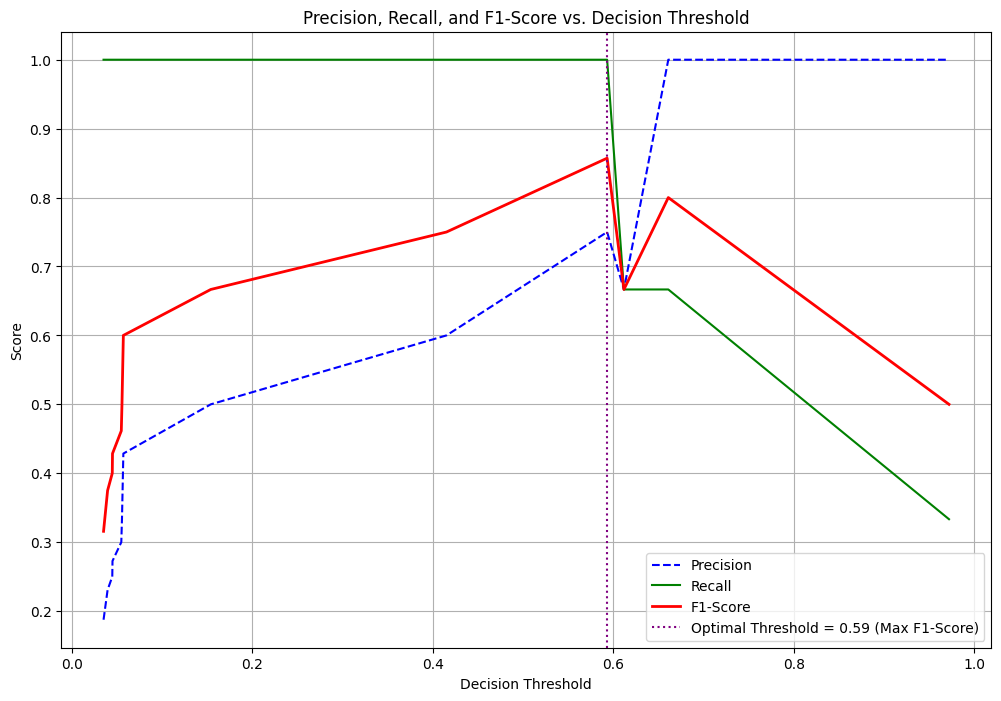

   - The default threshold is 0.5. However, the F1-score is maximized at a threshold of 0.5931.
   - This suggests that for the best balance of precision and recall, we could classify a wallet as 'Sybil' if its probability is > 0.59 instead of 0.5.


In [5]:
# --- 5. ADVANCED ANALYSIS: CURVES & THRESHOLDS ---

if 'y_pred_proba_test' in locals():
    print("\n" + "="*70)
    print("--- ADVANCED PERFORMANCE ANALYSIS ---")
    print("="*70)

    # 1. ROC and Precision-Recall Curves
    print("\nIV. CLASSIFICATION CURVE ANALYSIS\n" + "-"*50)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 9))

    RocCurveDisplay.from_predictions(y_test, y_pred_proba_test, ax=ax1, name='Model')
    ax1.plot([0, 1], [0, 1], 'k--', label='No-Skill Classifier')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
    ax1.legend()

    PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba_test, ax=ax2, name='Model')
    ax2.set_title('Precision-Recall Curve', fontsize=16)

    plt.suptitle('Model Classification Capability Visualization', fontsize=20)
    plt.show()
    print("   - ROC Curve: Shows the trade-off between True Positive Rate and False Positive Rate. Higher is better.")
    print("   - Precision-Recall Curve: More informative for imbalanced datasets. Shows the trade-off between Precision and Recall.")

    # 2. Optimal Threshold Analysis
    print("\nV. OPTIMAL DECISION THRESHOLD ANALYSIS\n" + "-"*50)
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
    # Calculate F1-score for each threshold
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    # Find the threshold that maximizes F1-score
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    plt.figure(figsize=(12, 8))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, f1_scores[:-1], "r-", label="F1-Score", linewidth=2)
    plt.axvline(optimal_threshold, color='purple', linestyle=':',
                label=f'Optimal Threshold = {optimal_threshold:.2f} (Max F1-Score)')
    plt.xlabel("Decision Threshold")
    plt.ylabel("Score")
    plt.title("Precision, Recall, and F1-Score vs. Decision Threshold")
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f"   - The default threshold is 0.5. However, the F1-score is maximized at a threshold of {optimal_threshold:.4f}.")
    print("   - This suggests that for the best balance of precision and recall, we could classify a wallet as 'Sybil' if its probability is > "
          f"{optimal_threshold:.2f} instead of 0.5.")

else:
    print("❌ No prediction probabilities for advanced analysis.")


--- MODEL CONFIDENCE & ERROR ANALYSIS ---

VI. MODEL CALIBRATION (PROBABILITY TRUSTWORTHINESS)
--------------------------------------------------


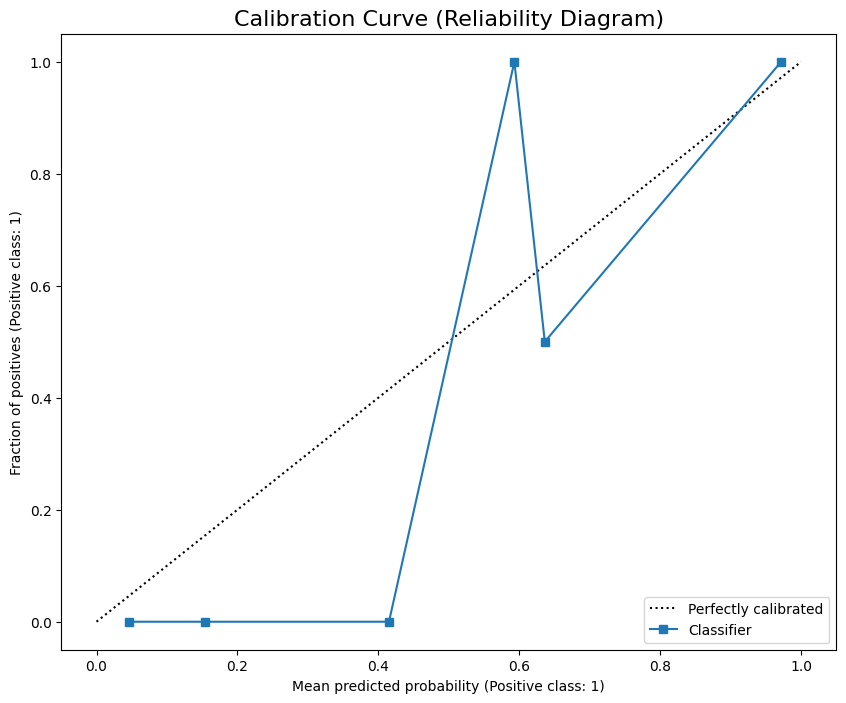

   - A perfectly calibrated model follows the diagonal dashed line.
   - This plot shows if the model's confidence scores are reliable. For example, when the model predicts a 90% probability, is it correct 90% of the time?

VII. ERROR ANALYSIS
--------------------------------------------------

🔴 The model made 1 errors. Analyzing them:

- 1 False Positives (Normal wallets incorrectly flagged as Sybil):


,wallet_address,label,predicted_label,probability_sybil
14,0x9690b5ebd6735504e0a622732fa56051883eb97313b9...,0,1,0.611692



- 0 False Negatives (Sybil wallets missed by the model):


In [6]:
# --- 6. MODEL CONFIDENCE & ERROR ANALYSIS ---

if 'y_pred_proba_test' in locals():
    print("\n" + "="*70)
    print("--- MODEL CONFIDENCE & ERROR ANALYSIS ---")
    print("="*70)

    # 1. Calibration Curve (Trustworthiness of Probabilities)
    print("\nVI. MODEL CALIBRATION (PROBABILITY TRUSTWORTHINESS)\n" + "-"*50)
    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba_test, n_bins=10, strategy='uniform')

    fig, ax = plt.subplots(figsize=(10, 8))
    CalibrationDisplay.from_predictions(y_test, y_pred_proba_test, n_bins=10, ax=ax)
    ax.set_title("Calibration Curve (Reliability Diagram)", fontsize=16)
    plt.show()
    print("   - A perfectly calibrated model follows the diagonal dashed line.")
    print("   - This plot shows if the model's confidence scores are reliable. For example, when the model predicts a 90% probability, is it correct 90% of the time?")

    # 2. Deep Dive into Errors
    print("\nVII. ERROR ANALYSIS\n" + "-"*50)
    results_df = test_df.copy()
    results_df['predicted_label'] = y_pred_test
    results_df['probability_sybil'] = y_pred_proba_test
    results_df['is_correct'] = (results_df['label'] == results_df['predicted_label'])

    incorrect_predictions = results_df[results_df['is_correct'] == False]

    if incorrect_predictions.empty:
        print("\n🎉 EXCELLENT! The model made no errors on the test set.")
    else:
        print(f"\n🔴 The model made {len(incorrect_predictions)} errors. Analyzing them:")

        # False Positives: Predicted Sybil, but was Non-Sybil
        false_positives = incorrect_predictions[incorrect_predictions['label'] == 0]
        print(f"\n- {len(false_positives)} False Positives (Normal wallets incorrectly flagged as Sybil):")
        if not false_positives.empty:
            display(false_positives[['wallet_address', 'label', 'predicted_label', 'probability_sybil']].head())

        # False Negatives: Predicted Non-Sybil, but was Sybil
        false_negatives = incorrect_predictions[incorrect_predictions['label'] == 1]
        print(f"\n- {len(false_negatives)} False Negatives (Sybil wallets missed by the model):")
        if not false_negatives.empty:
            display(false_negatives[['wallet_address', 'label', 'predicted_label', 'probability_sybil']].head())
else:
    print("❌ No prediction results for error analysis.")


--- AI MODEL PERFORMANCE DASHBOARD ---


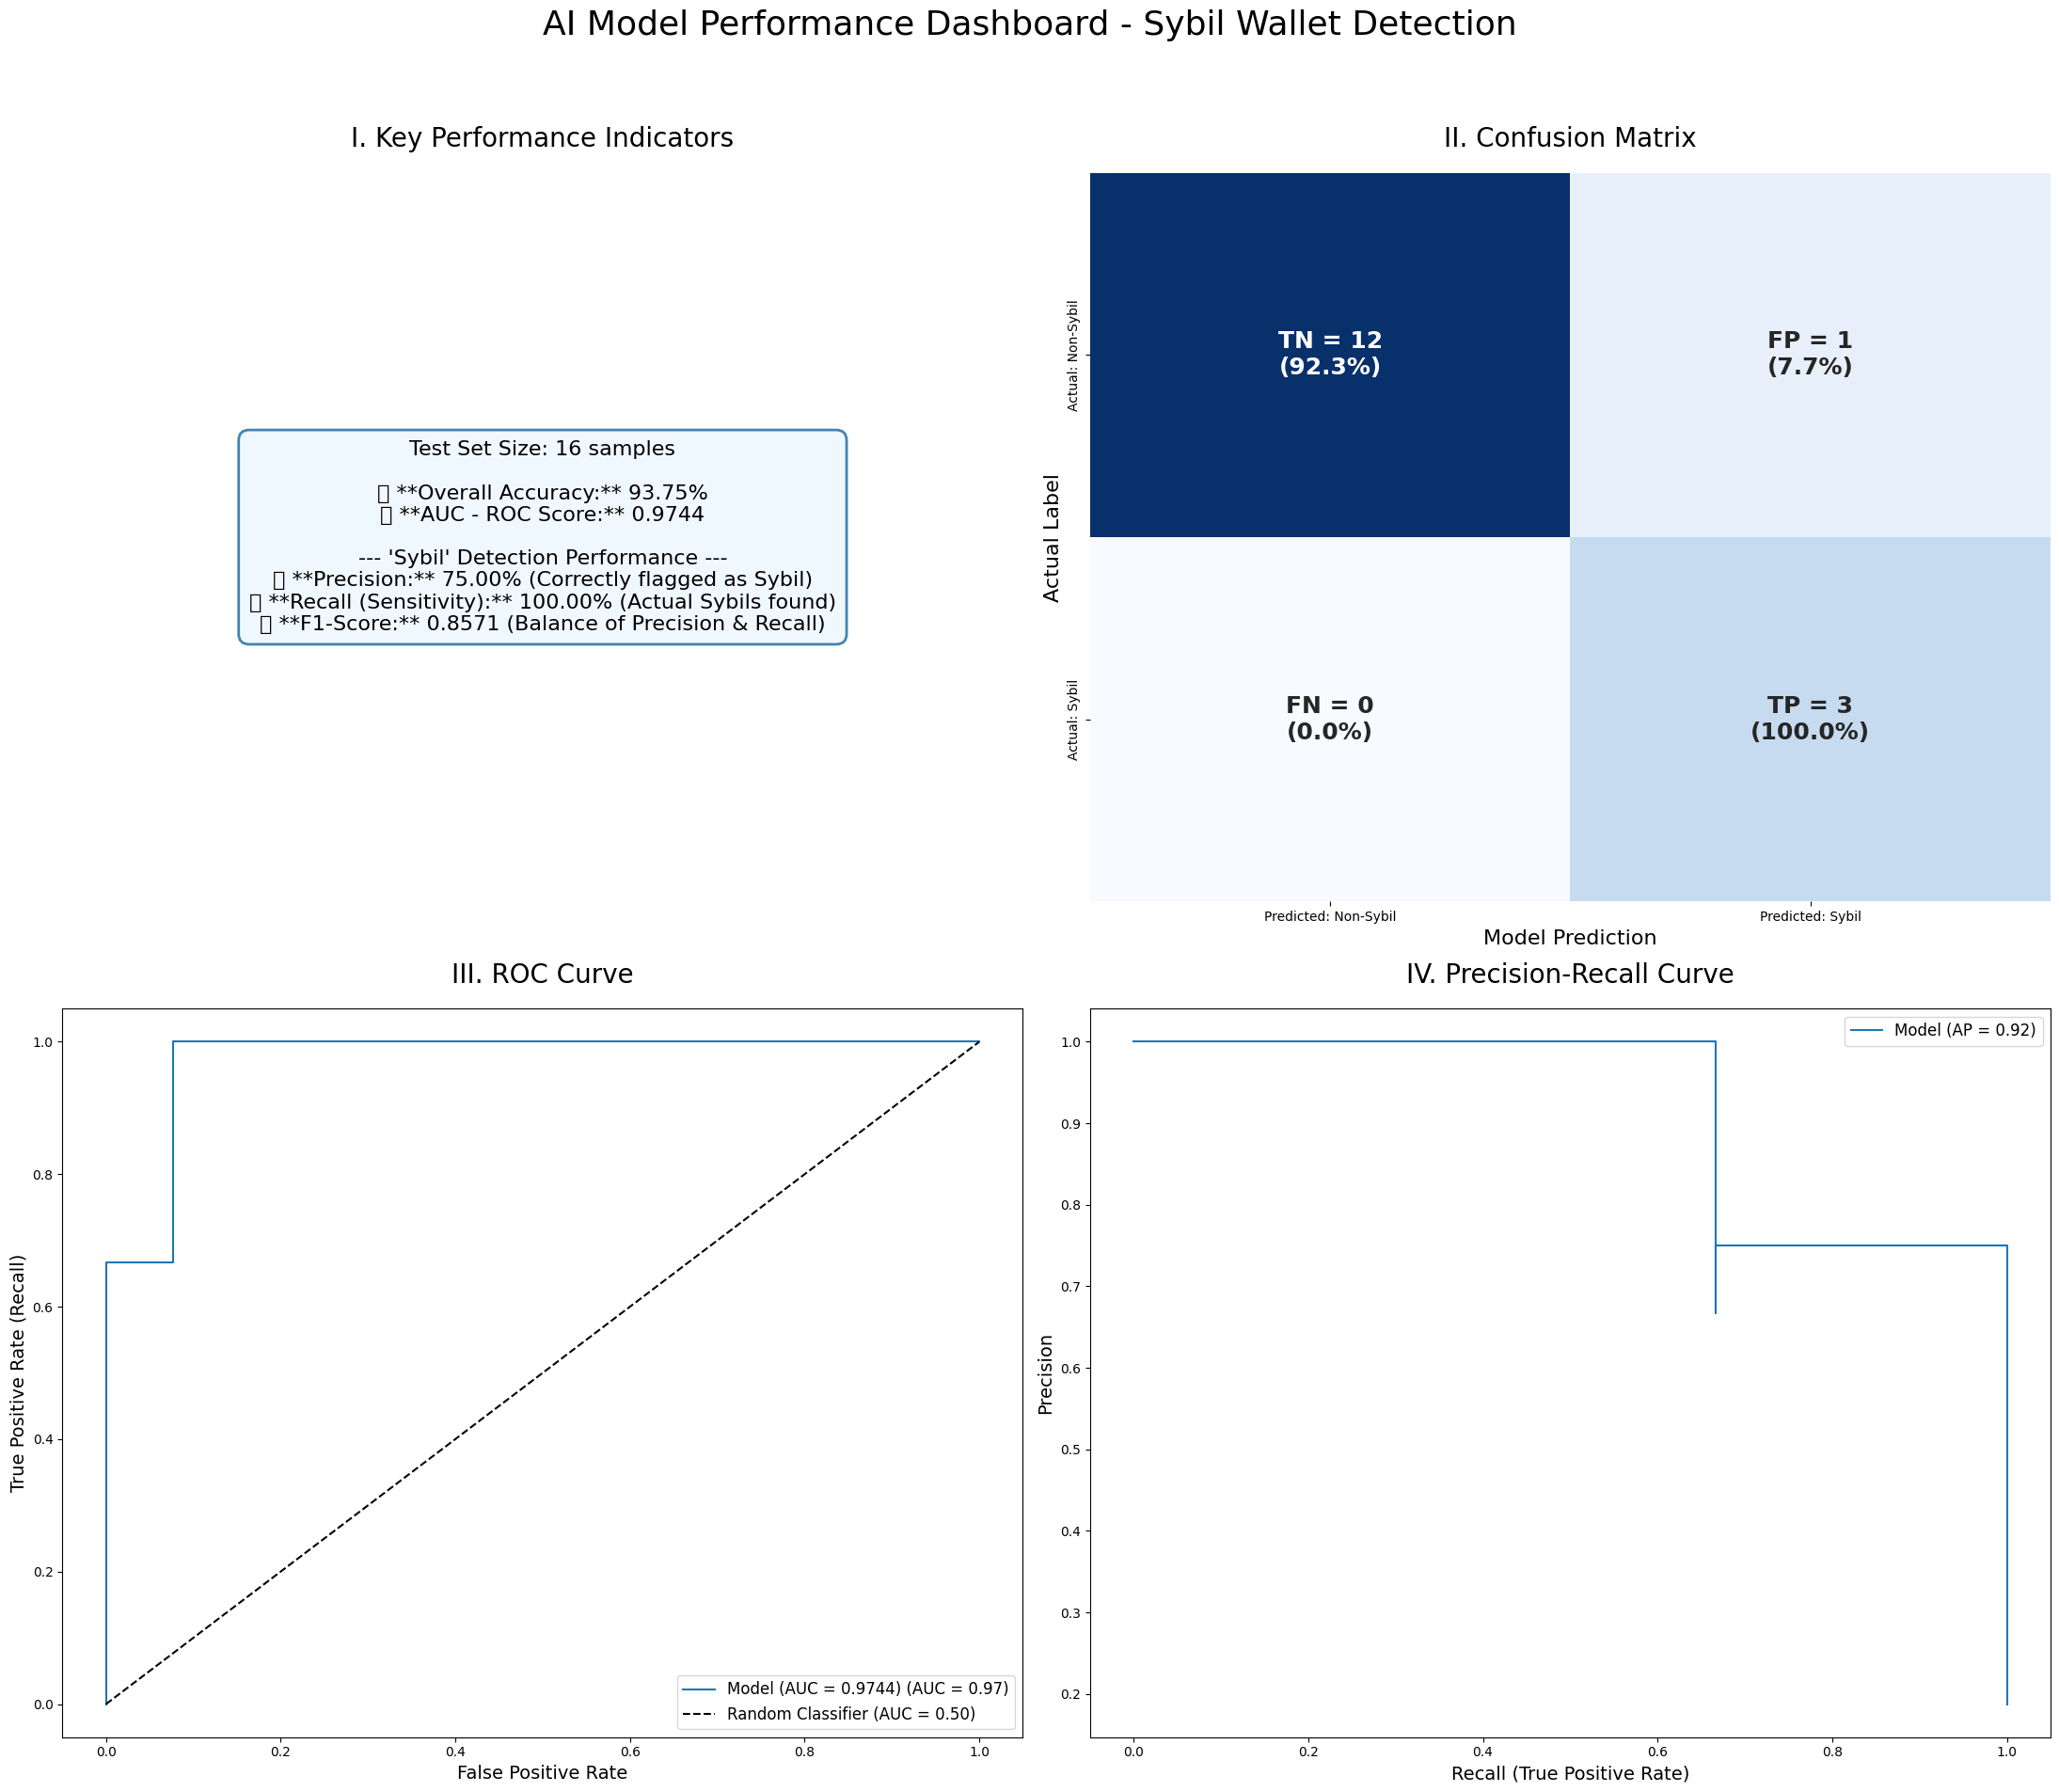

In [7]:
# --- 7. COMPREHENSIVE MODEL PERFORMANCE DASHBOARD ---

if 'y_pred_test' in locals() and 'y_pred_proba_test' in locals():
    print("\n" + "="*80)
    print("--- AI MODEL PERFORMANCE DASHBOARD ---")
    print("="*80)

    # --- A. CALCULATE ALL NECESSARY METRICS ---
    accuracy = accuracy_score(y_test, y_pred_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba_test)
    report_dict = classification_report(y_test, y_pred_test, target_names=['Non-Sybil', 'Sybil'], output_dict=True)

    # Metrics for the 'Sybil' class
    precision_sybil = report_dict['Sybil']['precision']
    recall_sybil = report_dict['Sybil']['recall']
    f1_sybil = report_dict['Sybil']['f1-score']

    # Confusion Matrix values
    cm = confusion_matrix(y_test, y_pred_test)
    tn, fp, fn, tp = cm.flatten()

    # --- B. CREATE THE COMPREHENSIVE DASHBOARD PLOT ---
    fig, ax = plt.subplots(2, 2, figsize=(22, 20))
    ((ax1, ax2), (ax3, ax4)) = ax

    fig.suptitle('AI Model Performance Dashboard - Sybil Wallet Detection', fontsize=26, y=0.98)

    # --- Plot 1: Key Performance Indicators (KPIs) ---
    ax1.axis('off')
    ax1.set_title('I. Key Performance Indicators', fontsize=20, pad=20)

    metrics_text = (
        f"Test Set Size: {len(y_test)} samples\n\n"
        f"🎯 **Overall Accuracy:** {accuracy:.2%}\n"
        f"📈 **AUC - ROC Score:** {roc_auc:.4f}\n\n"
        "--- 'Sybil' Detection Performance ---\n"
        f"🔍 **Precision:** {precision_sybil:.2%} (Correctly flagged as Sybil)\n"
        f"🎯 **Recall (Sensitivity):** {recall_sybil:.2%} (Actual Sybils found)\n"
        f"📊 **F1-Score:** {f1_sybil:.4f} (Balance of Precision & Recall)"
    )

    ax1.text(0.5, 0.5, metrics_text, ha='center', va='center', fontsize=16,
             bbox=dict(boxstyle="round,pad=0.5", fc="#f0f8ff", ec="#4682b4", lw=2))

    # --- Plot 2: Enhanced Confusion Matrix ---
    ax2.set_title('II. Confusion Matrix', fontsize=20, pad=20)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    labels = (np.asarray([f"TN = {tn}\n({cm_percent[0,0]:.1%})", f"FP = {fp}\n({cm_percent[0,1]:.1%})",
                          f"FN = {fn}\n({cm_percent[1,0]:.1%})", f"TP = {tp}\n({cm_percent[1,1]:.1%})"])
             ).reshape(2, 2)

    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax2,
                xticklabels=['Predicted: Non-Sybil', 'Predicted: Sybil'],
                yticklabels=['Actual: Non-Sybil', 'Actual: Sybil'],
                annot_kws={"size": 18, "weight": "bold"}, cbar=False)
    ax2.set_xlabel('Model Prediction', fontsize=16)
    ax2.set_ylabel('Actual Label', fontsize=16)

    # --- Plot 3: Receiver Operating Characteristic (ROC) Curve ---
    ax3.set_title('III. ROC Curve', fontsize=20, pad=20)
    RocCurveDisplay.from_predictions(y_test, y_pred_proba_test, ax=ax3, name=f'Model (AUC = {roc_auc:.4f})')
    ax3.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
    ax3.legend(fontsize=12)
    ax3.set_xlabel('False Positive Rate', fontsize=14)
    ax3.set_ylabel('True Positive Rate (Recall)', fontsize=14)

    # --- Plot 4: Precision-Recall Curve ---
    ax4.set_title('IV. Precision-Recall Curve', fontsize=20, pad=20)
    PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba_test, ax=ax4, name='Model')
    ax4.legend(fontsize=12)
    ax4.set_xlabel('Recall (True Positive Rate)', fontsize=14)
    ax4.set_ylabel('Precision', fontsize=14)

    # --- C. DISPLAY THE PLOT ---
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

else:
    print("❌ No prediction results found to generate the dashboard.")